# EDA - Reporte de Datos – Heart Failure Prediction

Este notebook contiene el  reporte de datos asociado a la fase de análisis exploratorio de datos (EDA) para el dataset de Heart Failure Prediction.




In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 10

## Carga de los datos

In [2]:
DATA_PATH = "/Users/dsovallec/Documents/Maestria/Metodologias_agiles/heart.csv"  

df = pd.read_csv(DATA_PATH)

data = df.copy()

data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


## 1. Resumen general de los datos

In [3]:
print("Dimensiones del dataset (filas, columnas):", data.shape)
print("\nTipos de datos:")
print(data.dtypes)

print("\nEstadísticas descriptivas (variables numéricas):")
display(data.describe().T)

print("\nValores únicos por columna:")
print(data.nunique())

Dimensiones del dataset (filas, columnas): (918, 12)

Tipos de datos:
Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

Estadísticas descriptivas (variables numéricas):


,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0



Valores únicos por columna:
Age                50
Sex                 2
ChestPainType       4
RestingBP          67
Cholesterol       222
FastingBS           2
RestingECG          3
MaxHR             119
ExerciseAngina      2
Oldpeak            53
ST_Slope            3
HeartDisease        2
dtype: int64


In [4]:
target_col = "HeartDisease"  
if target_col not in data.columns:
    raise ValueError(f"La columna objetivo '{target_col}' no existe en el dataset. Revisa el nombre.")

data[target_col].value_counts(normalize=False).rename("conteo")

HeartDisease
1    508
0    410
Name: conteo, dtype: int64

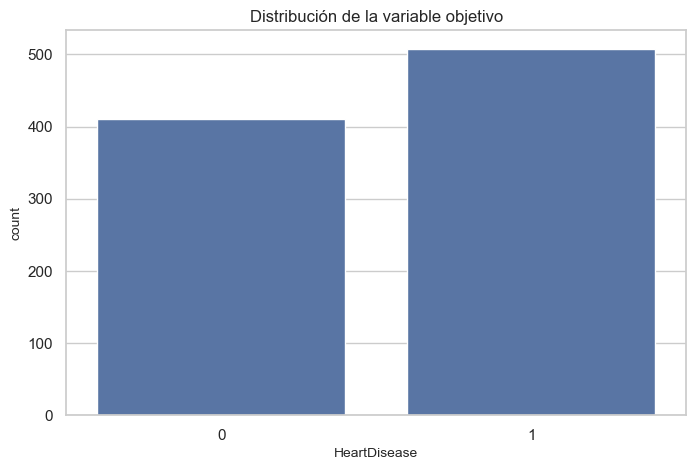

In [30]:
fig, ax = plt.subplots()
sns.countplot(x=target_col, data=data, ax=ax)
ax.set_title("Distribución de la variable objetivo")
plt.show()

## 2. Resumen de calidad de los datos

In [5]:
missing = data.isna().sum().to_frame("n_missing")
missing["pct_missing"] = 100 * missing["n_missing"] / len(data)
missing

,n_missing,pct_missing
Age,0,0.0
Sex,0,0.0
ChestPainType,0,0.0
RestingBP,0,0.0
Cholesterol,0,0.0
FastingBS,0,0.0
RestingECG,0,0.0
MaxHR,0,0.0
ExerciseAngina,0,0.0
Oldpeak,0,0.0


In [6]:
n_duplicated = data.duplicated().sum()
print(f"Número de filas duplicadas: {n_duplicated}")


Número de filas duplicadas: 0


In [7]:
# rango intercuartilico
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
iqr_summary = []

for col in numeric_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = ((data[col] < lower) | (data[col] > upper)).sum()
    iqr_summary.append([col, lower, upper, outliers])

iqr_df = pd.DataFrame(iqr_summary, columns=["columna", "limite_inferior", "limite_superior", "n_outliers"])
iqr_df

,columna,limite_inferior,limite_superior,n_outliers
0,Age,27.500,79.500,0
1,RestingBP,90.000,170.000,28
2,Cholesterol,32.625,407.625,183
3,FastingBS,0.000,0.000,214
4,MaxHR,66.000,210.000,2
5,Oldpeak,-2.250,3.750,16
6,HeartDisease,-1.500,2.500,0


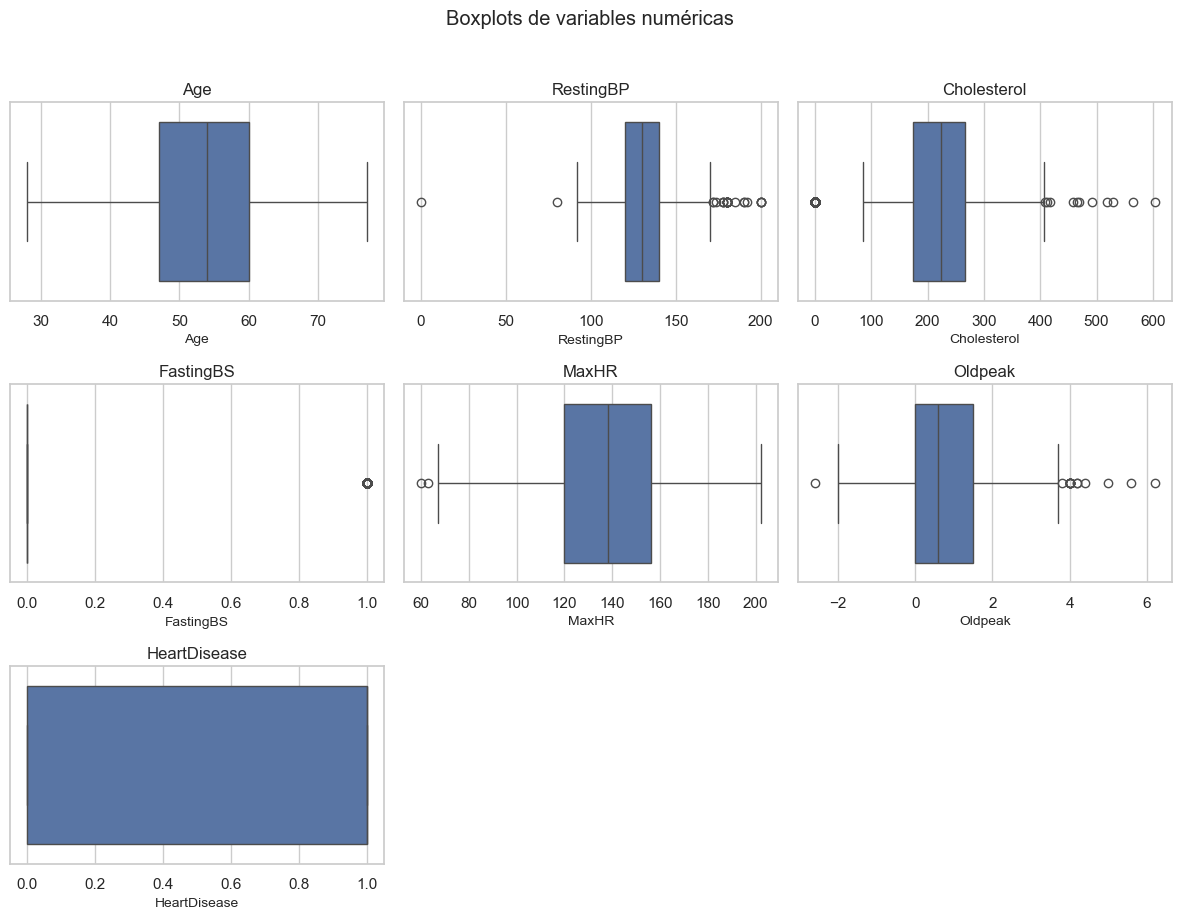

In [8]:
# boxplots globales para visualizar posibles outliers
n_cols = 3
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.boxplot(x=data[col], ax=axes[i])
    axes[i].set_title(col)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Boxplots de variables numéricas", y=1.02)
plt.tight_layout()
plt.show()

## 3. Variable objetivo

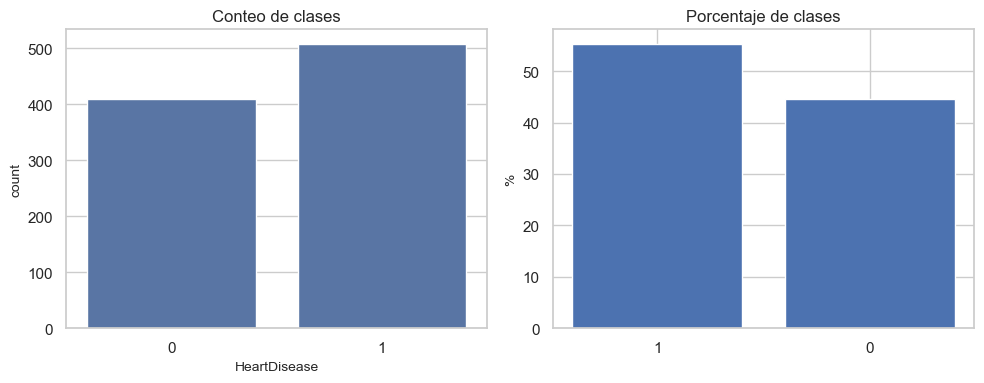

In [9]:
# proporción de clases en variable objetivo
class_counts = data[target_col].value_counts()
class_pct = 100 * class_counts / len(data)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.countplot(x=target_col, data=data, ax=ax[0])
ax[0].set_title("Conteo de clases")

ax[1].bar(class_pct.index.astype(str), class_pct.values)
ax[1].set_title("Porcentaje de clases")
ax[1].set_ylabel("%")

plt.tight_layout()
plt.show()

## 4. Variables individuales

In [10]:
numeric_cols = [c for c in data.columns if data[c].dtype != 'O' and c != target_col]
categorical_cols = [c for c in data.columns if data[c].dtype == 'O']

print("Variables numéricas:", numeric_cols)
print("Variables categóricas:", categorical_cols)

Variables numéricas: ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
Variables categóricas: ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


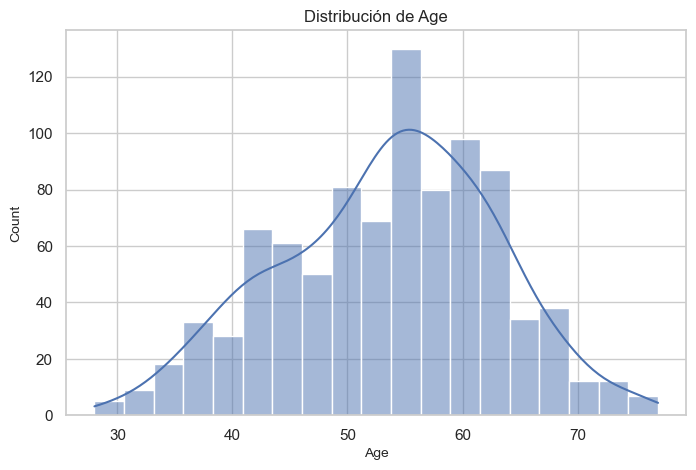

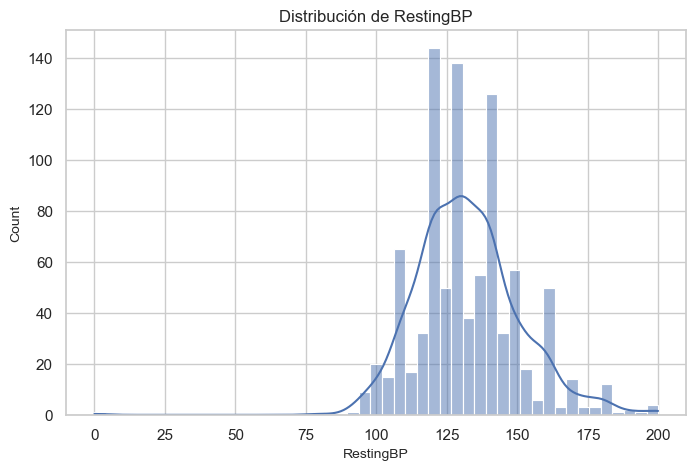

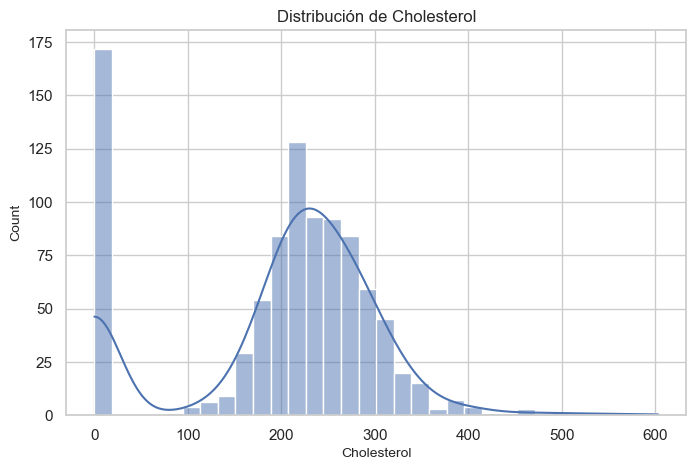

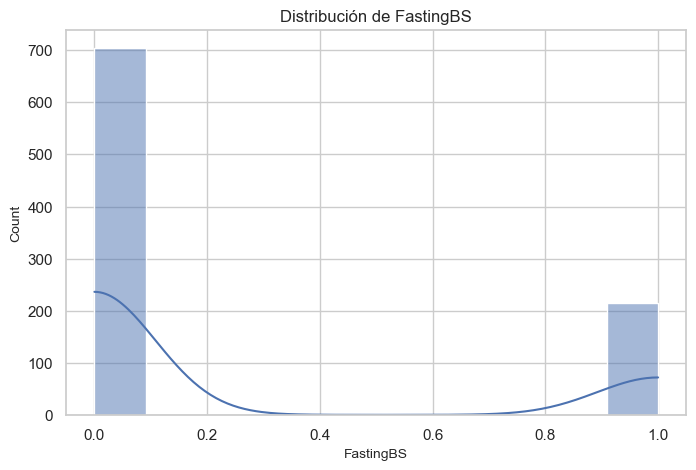

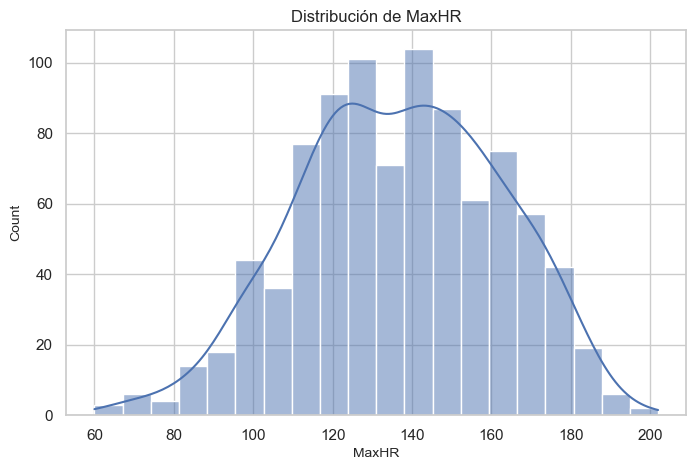

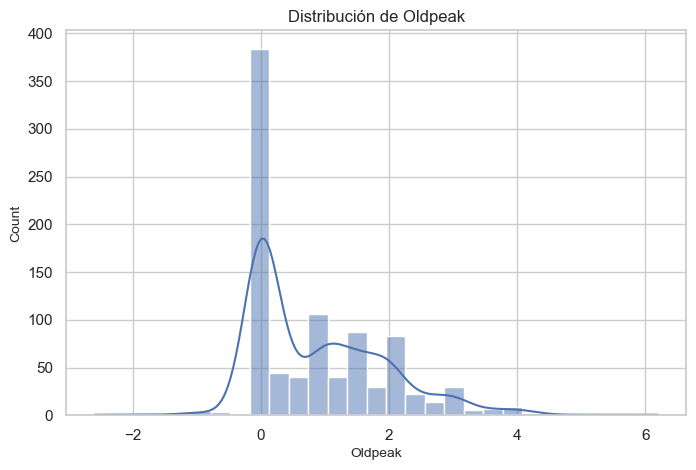

In [11]:
# Histograma para cada variable numérica
for col in numeric_cols:
    fig, ax = plt.subplots()
    sns.histplot(data[col], kde=True, ax=ax)
    ax.set_title(f"Distribución de {col}")
    plt.show()

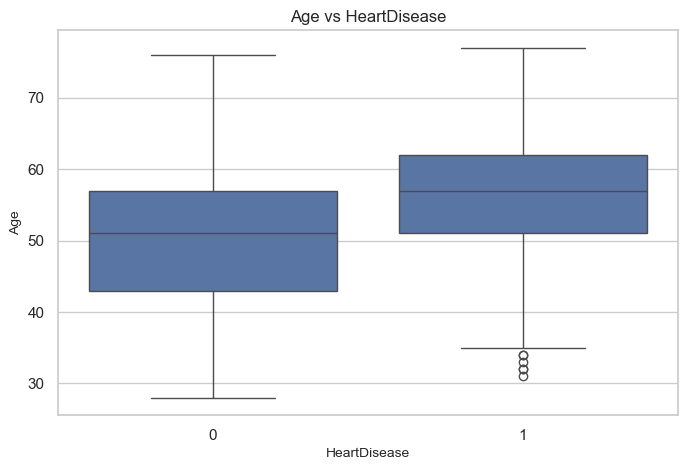

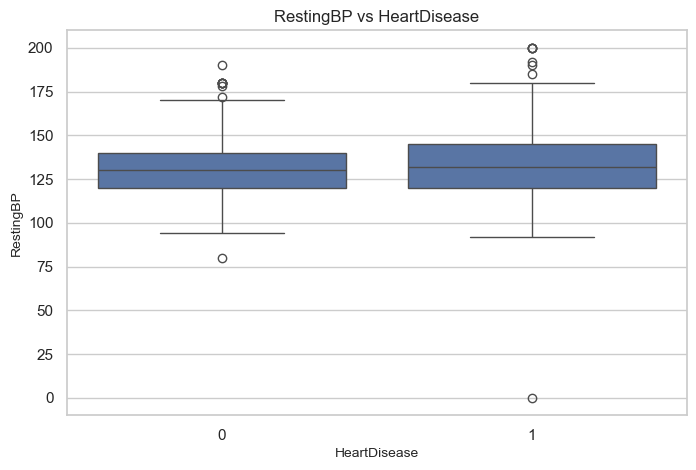

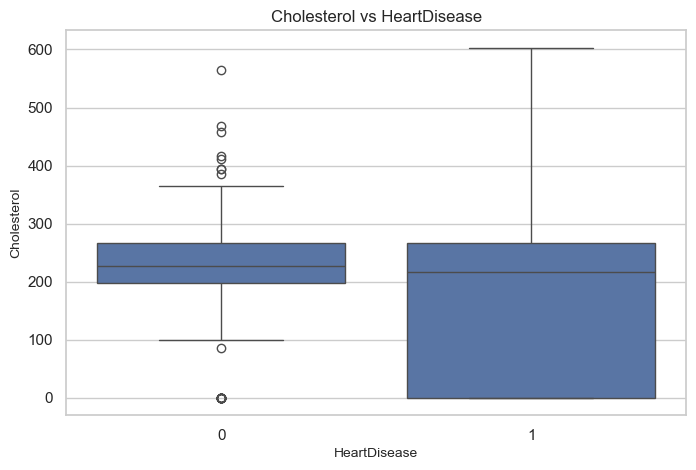

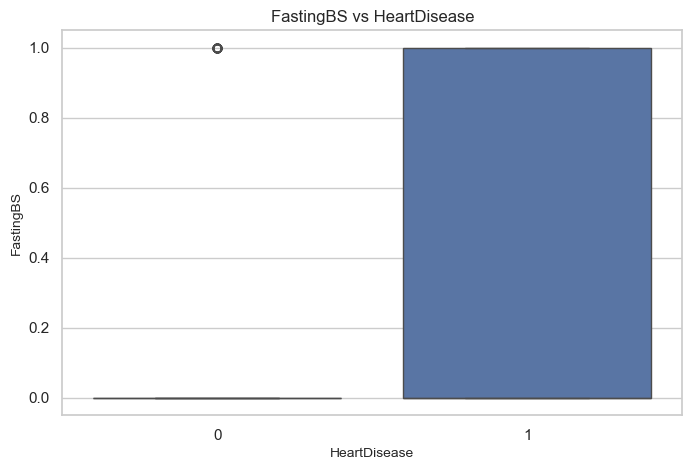

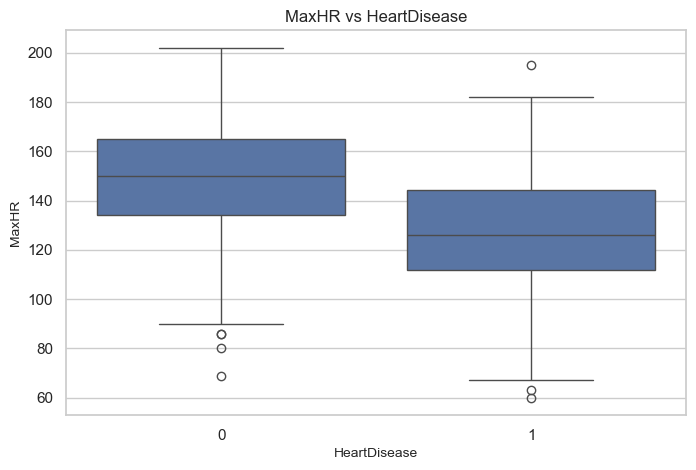

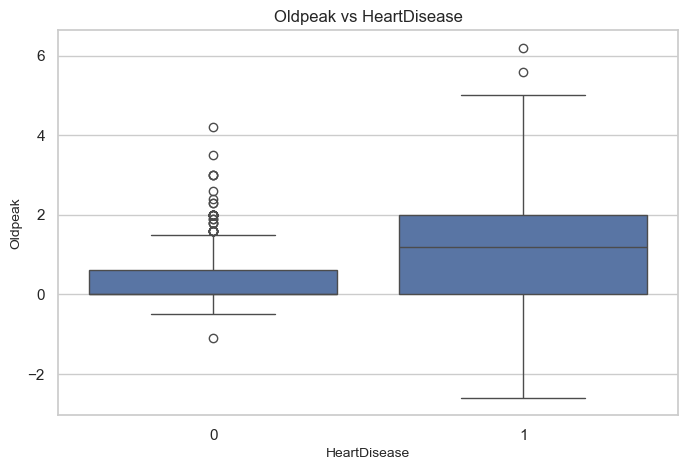

In [12]:
# Relación de cada variable numérica con la variable objetivo (boxplot)
for col in numeric_cols:
    fig, ax = plt.subplots()
    sns.boxplot(x=target_col, y=col, data=data, ax=ax)
    ax.set_title(f"{col} vs {target_col}")
    plt.show()

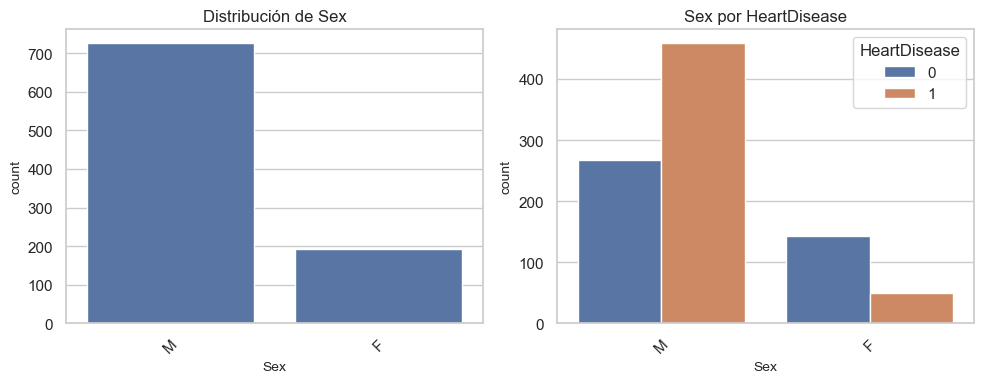

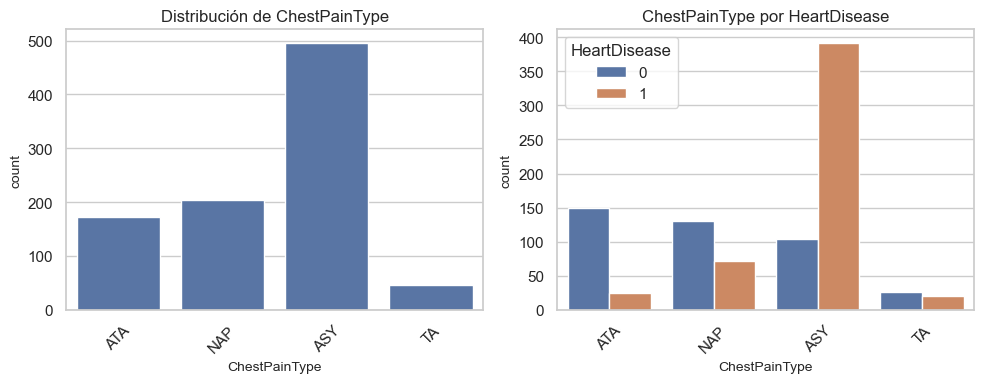

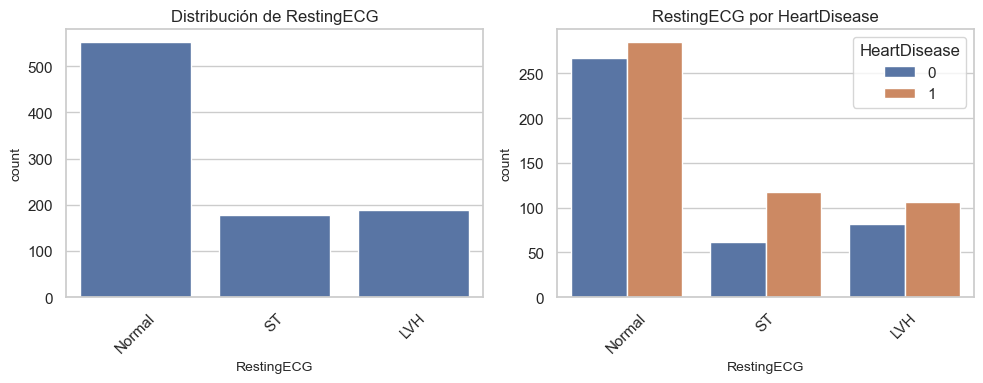

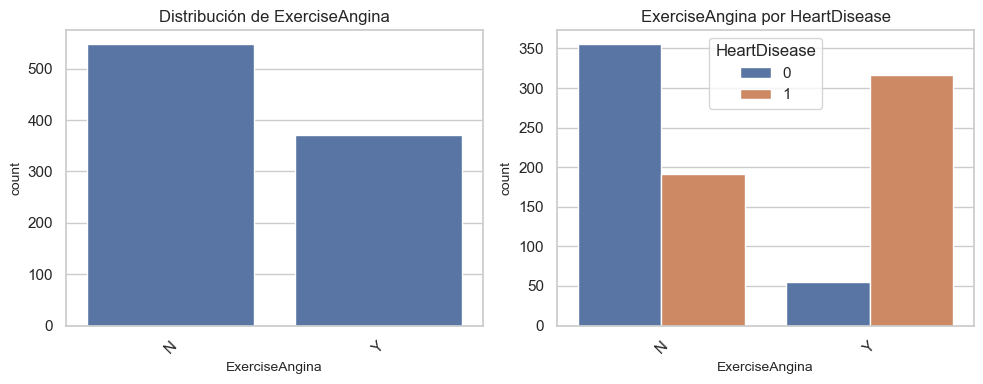

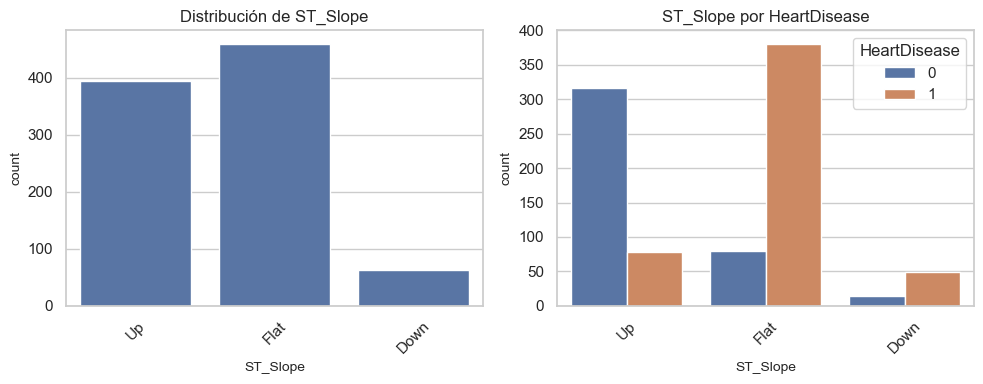

In [13]:
# Análisis univariado de variables categóricas 
for col in categorical_cols:
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    
    sns.countplot(x=col, data=data, ax=ax[0])
    ax[0].set_title(f"Distribución de {col}")
    ax[0].tick_params(axis='x', rotation=45)
    
    sns.countplot(x=col, hue=target_col, data=data, ax=ax[1])
    ax[1].set_title(f"{col} por {target_col}")
    ax[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

## 5. Ranking de variables

In [14]:
# Matriz de correlación con la variable objetivo
corr = data[numeric_cols + [target_col]].corr()[target_col].drop(target_col)
corr_sorted = corr.sort_values(ascending=False)
corr_sorted

Oldpeak        0.403951
Age            0.282039
FastingBS      0.267291
RestingBP      0.107589
Cholesterol   -0.232741
MaxHR         -0.400421
Name: HeartDisease, dtype: float64

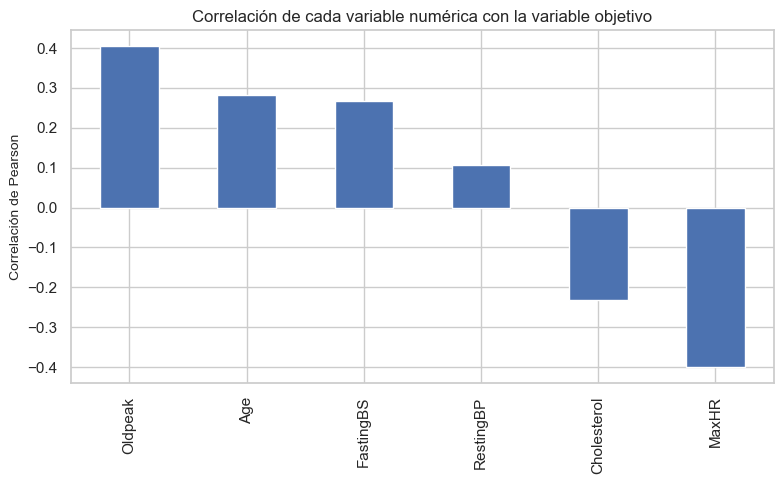

In [15]:
# Gráfico de correlación con la variable objetivo
fig, ax = plt.subplots()
corr_sorted.plot(kind="bar", ax=ax)
ax.set_title("Correlación de cada variable numérica con la variable objetivo")
ax.set_ylabel("Correlación de Pearson")
plt.tight_layout()
plt.show()

In [16]:
# Preparación de datos para modelos de importancia de variables
X = data.drop(columns=[target_col])
y = data[target_col]

# One-hot encoding para variables categóricas 
X = pd.get_dummies(X, drop_first=True)

# División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Escalado para modelos lineales
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
# Modelo 1: Regresión logística
log_reg = LogisticRegression(max_iter=500, n_jobs=-1)
log_reg.fit(X_train_scaled, y_train)

y_pred_proba_lr = log_reg.predict_proba(X_test_scaled)[:, 1]
auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
print(f"ROC-AUC Regresión logística: {auc_lr:.3f}")

coef_importance = pd.Series(log_reg.coef_[0], index=X_train.columns)
coef_importance = coef_importance.abs().sort_values(ascending=False)

coef_importance.head(15)

ROC-AUC Regresión logística: 0.932


ST_Slope_Up          0.834624
ChestPainType_NAP    0.803084
ChestPainType_ATA    0.619073
FastingBS            0.507785
Cholesterol          0.471724
Sex_M                0.454916
ExerciseAngina_Y     0.421684
ChestPainType_TA     0.417888
ST_Slope_Flat        0.339627
Oldpeak              0.237388
MaxHR                0.230906
RestingECG_Normal    0.224605
RestingECG_ST        0.200575
Age                  0.056519
RestingBP            0.009515
dtype: float64

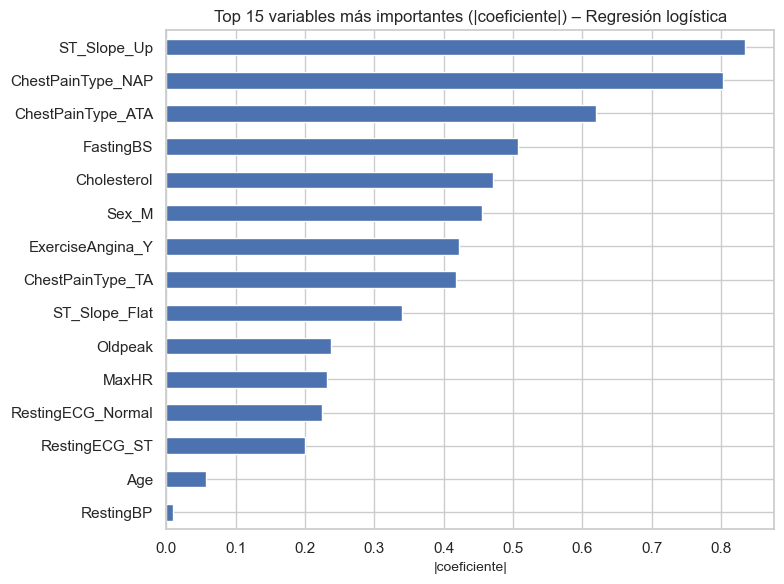

In [47]:
# Gráfico de importancia (regresión logística)
top_n = 15
fig, ax = plt.subplots(figsize=(8, 6))
coef_importance.head(top_n).plot(kind="barh", ax=ax)
ax.invert_yaxis()
ax.set_title(f"Top {top_n} variables más importantes (|coeficiente|) – Regresión logística")
ax.set_xlabel("|coeficiente|")
plt.tight_layout()
plt.show()

In [18]:
# Modelo 2: Random Forest
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print(f"ROC-AUC Random Forest: {auc_rf:.3f}")

rf_importance = pd.Series(rf.feature_importances_, index=X_train.columns)
rf_importance = rf_importance.sort_values(ascending=False)

rf_importance.head(15)

ROC-AUC Random Forest: 0.948


ST_Slope_Up          0.162978
MaxHR                0.114963
Oldpeak              0.107493
Cholesterol          0.105228
ST_Slope_Flat        0.103344
Age                  0.083335
ExerciseAngina_Y     0.080152
RestingBP            0.077541
ChestPainType_ATA    0.036229
Sex_M                0.035048
ChestPainType_NAP    0.030874
FastingBS            0.024352
RestingECG_Normal    0.018878
ChestPainType_TA     0.010067
RestingECG_ST        0.009518
dtype: float64

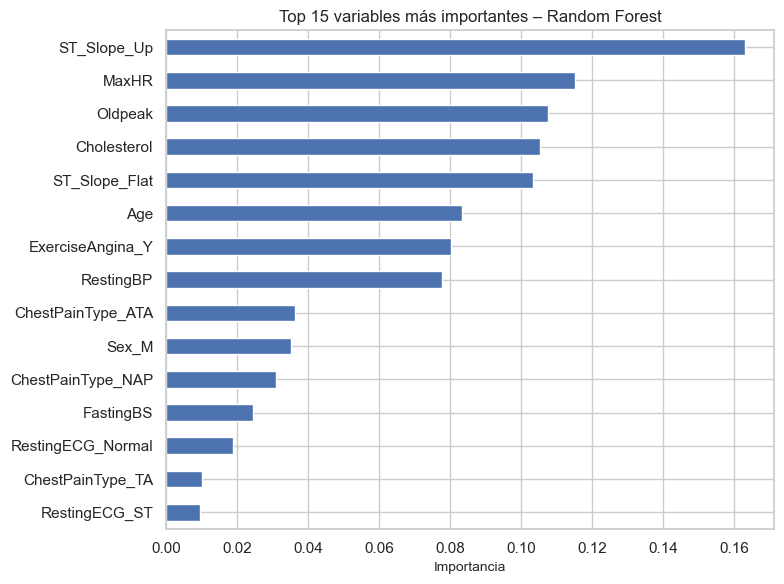

In [19]:
# Gráfico de importancia (Random Forest)
top_n = 15
fig, ax = plt.subplots(figsize=(8, 6))
rf_importance.head(top_n).plot(kind="barh", ax=ax)
ax.invert_yaxis()
ax.set_title(f"Top {top_n} variables más importantes – Random Forest")
ax.set_xlabel("Importancia")
plt.tight_layout()
plt.show()

## 6. Relación entre variables explicativas y variable objetivo

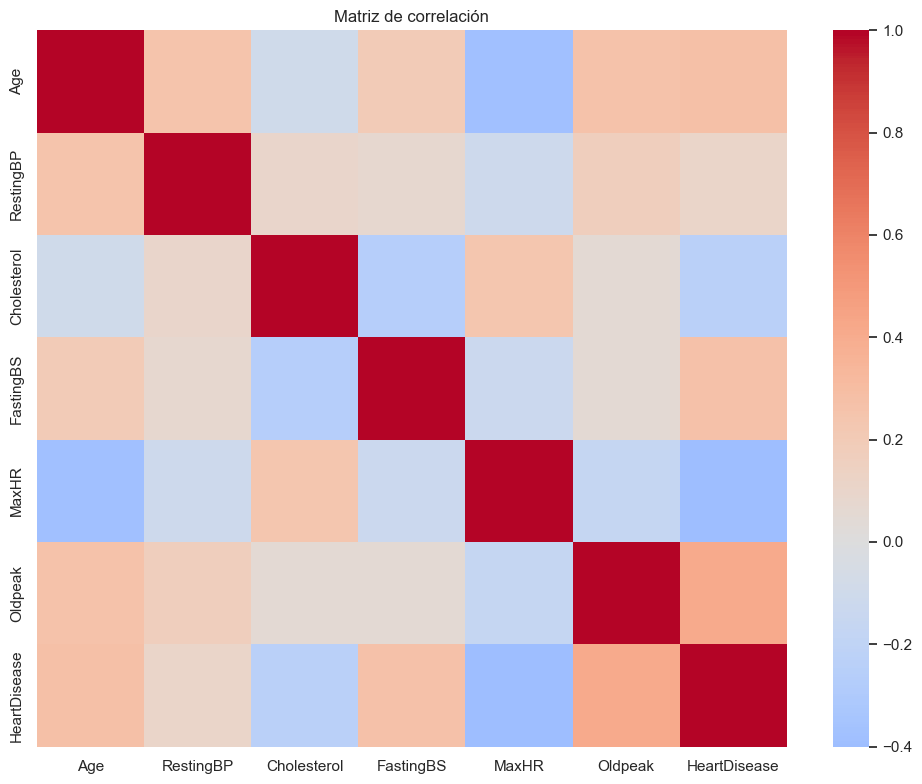

In [20]:
# Matriz de correlación entre variables numéricas
corr_matrix = data[numeric_cols + [target_col]].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", center=0)
plt.title("Matriz de correlación")
plt.tight_layout()
plt.show()

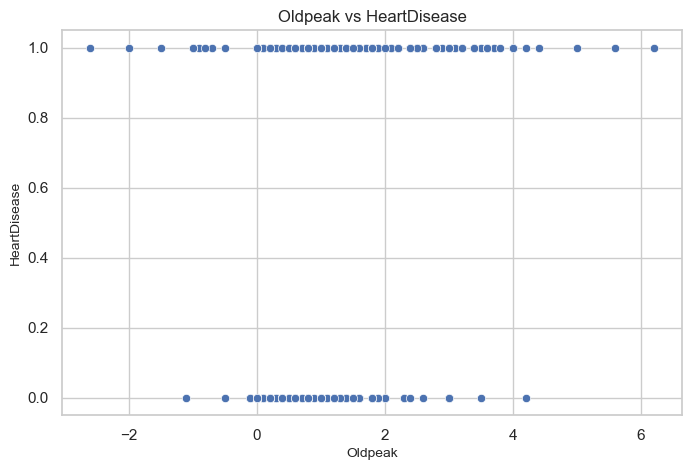

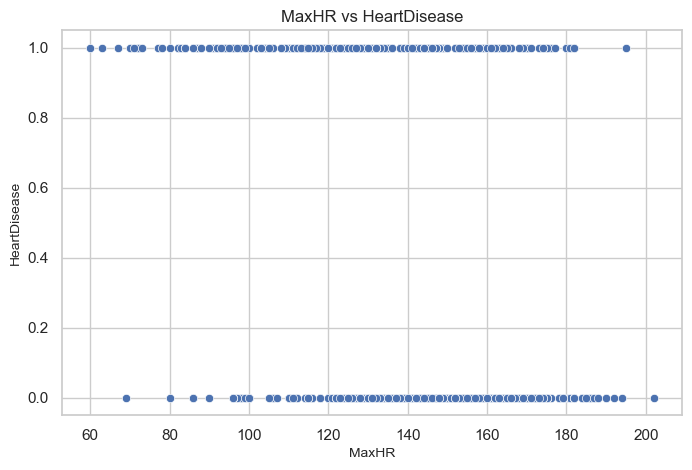

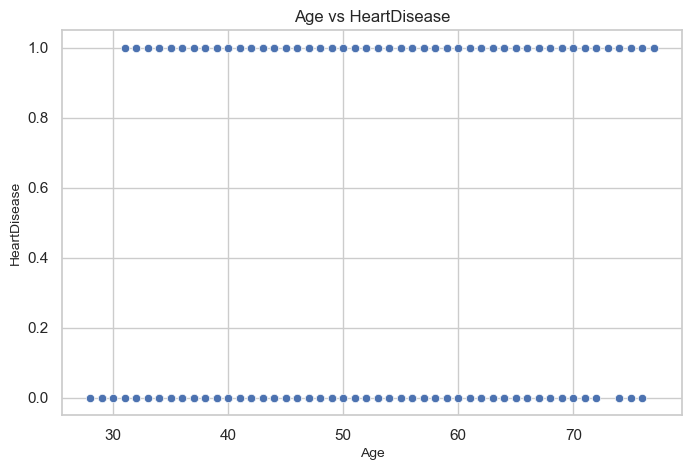

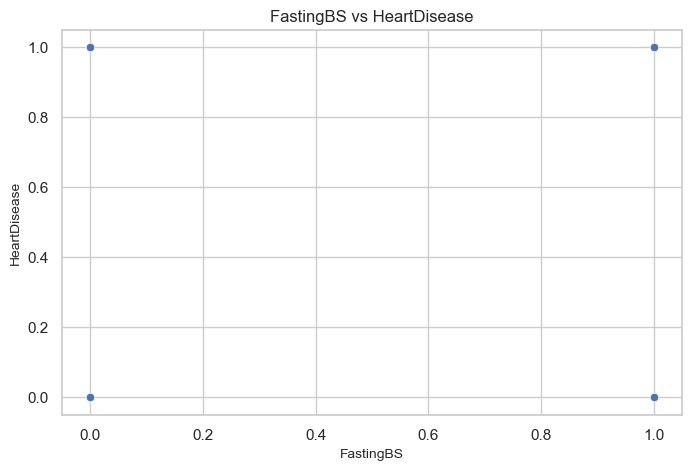

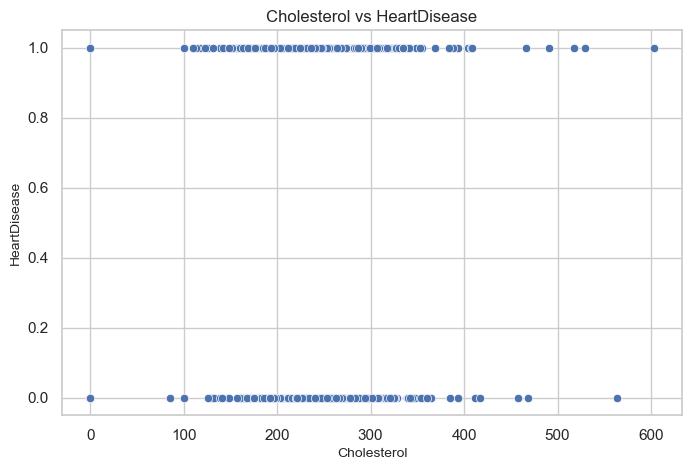

In [21]:
# Scatterplots seleccionados para variables con mayor correlación absoluta con la variable objetivo
top_corr_features = corr.abs().sort_values(ascending=False).head(5).index.tolist()

for col in top_corr_features:
    fig, ax = plt.subplots()
    sns.scatterplot(x=col, y=target_col, data=data, ax=ax)
    ax.set_title(f"{col} vs {target_col}")
    plt.show()

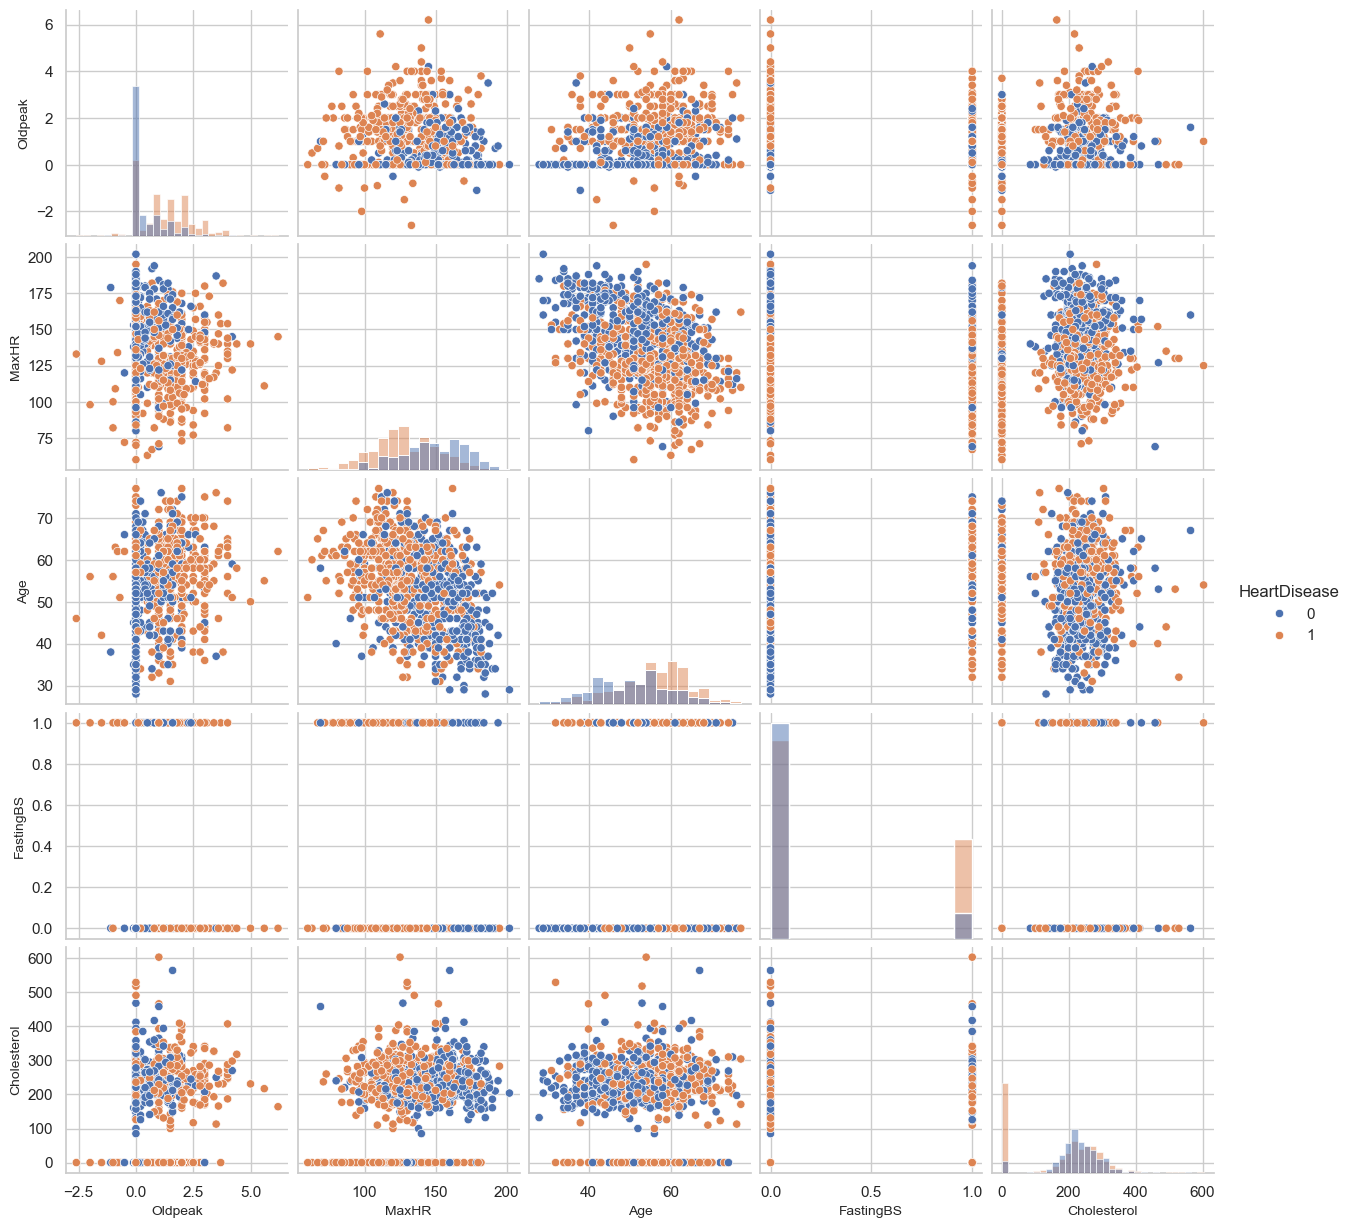

In [22]:
subset_cols = top_corr_features + [target_col]

sns.pairplot(data[subset_cols], hue=target_col, diag_kind="hist")
plt.show()